# Stock Price Prediction using Echo State Networks

## Introduction

Time Series Prediction is one important regression task, which can be solved using several machine learning techniques.

In this notebook, we briefly introduce one very basic example for time series prediction:

Stock Price Prediction

Disclaimer: We are signal processing experts, not financial advisors. Do not use any of the models presented herein to steer your investments.

At first, we need to import all required packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from pyrcn.echo_state_network import ESNRegressor
from pyrcn.linear_model import IncrementalRegression
from pyrcn.base.blocks import InputToNode, NodeToNode

sns.set_theme()

## Loading and visualizing stock prices

A good ressource for stock prices is Yahoo Finance ([https://finance.yahoo.com/](https://finance.yahoo.com/)), where a
lot of financial data can be downloaded as csv files.

We have already downloaded several stock prices, which are all stored in the directory "dataset".

Now, we are working with the gold price in USD (Gold Aug 20(GC=F)) between 2000-02-28 and 2020-05-28.

In [2]:
df = pd.read_csv("./GC=F.csv", delimiter=",")

Analyzing the dataset, we can analyze the structure. The first column is the date, the second column is the open value,
e.g. the first value of a day.
The third column is the highest value of a specific day, the fourth column the lowest and "Close" is the final value of
a day. The "Adj Close" is a corrected  final value, I DON 'T YET KNOW ANYTHING ABOUT VOLUME!!!

Here, we just use the "Close" value, the final value of one day. 

In [7]:
df.head(n=10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-28,292.299988,292.500000,292.299988,292.500000,292.500000,4.0
1,2000-02-29,292.399994,292.399994,292.399994,292.399994,292.399994,7.0
2,2000-03-01,291.500000,291.500000,291.500000,291.500000,291.500000,0.0
3,2000-03-02,288.200012,291.500000,288.000000,288.200012,288.200012,100.0
4,2000-03-03,288.799988,288.799988,288.799988,288.799988,288.799988,10.0
5,2000-03-05,NaN,NaN,NaN,NaN,NaN,NaN
6,2000-03-06,287.899994,287.899994,287.899994,287.899994,287.899994,0.0
7,2000-03-07,292.200012,292.200012,292.200012,292.200012,292.200012,0.0
8,2000-03-08,288.899994,288.899994,288.899994,288.899994,288.899994,100.0
9,2000-03-09,291.200012,291.200012,291.200012,291.200012,291.200012,0.0


In [11]:
df.dropna(inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.head(n=10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-28,292.299988,292.500000,292.299988,292.500000,292.500000,4.0
1,2000-02-29,292.399994,292.399994,292.399994,292.399994,292.399994,7.0
2,2000-03-01,291.500000,291.500000,291.500000,291.500000,291.500000,0.0
3,2000-03-02,288.200012,291.500000,288.000000,288.200012,288.200012,100.0
4,2000-03-03,288.799988,288.799988,288.799988,288.799988,288.799988,10.0
6,2000-03-06,287.899994,287.899994,287.899994,287.899994,287.899994,0.0
7,2000-03-07,292.200012,292.200012,292.200012,292.200012,292.200012,0.0
8,2000-03-08,288.899994,288.899994,288.899994,288.899994,288.899994,100.0
9,2000-03-09,291.200012,291.200012,291.200012,291.200012,291.200012,0.0
10,2000-03-10,288.600006,288.600006,288.600006,288.600006,288.600006,4.0


As one can see, the stock price trends upwards for the first few thousand days. Then goes down at around $n=3300$ before climbing again after around $n = 4900$. 

<AxesSubplot:xlabel='Date', ylabel='Close'>

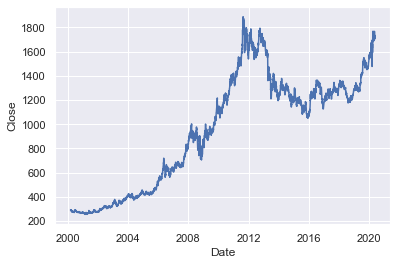

In [12]:
fig, axs = plt.subplots()
sns.lineplot(data=df, x="Date", y="Close", ax=axs)

We pre-processed the dataset by removing undefined values, namely, weekends and public holidays. The remaining values were normalized to be in a range of $[0 1]$.

In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X=df[["Close"]])

Define Train/Test lengths:

The first 3000 values were used to train the ESN and to optimize the hyper-parameters and the rest for testing. 

In [15]:
train_len = 3000
future_len = 1
future_total = len(X) - train_len

Echo State Network preparation

In [18]:
base_input_to_nodes = InputToNode(hidden_layer_size=100, input_activation='identity',
                                  k_in=1, input_scaling=0.6, bias_scaling=0.0)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=100, spectral_radius=0.9, leakage=1.0, k_rec=10)

esn = ESNRegressor(input_to_node=base_input_to_nodes,
                   node_to_node=base_nodes_to_nodes,
                   regressor=IncrementalRegression(alpha=1e-8), random_state=10)

Training and Prediction.

In [19]:
X_train = X[0:train_len, :]
y_train = X[0+1:train_len+1, :]
X_test = X[0:train_len+future_total - future_len, :]
y_test = X[future_len:train_len+future_total, :]

esn.fit(X=X_train, y=y_train.ravel())
y_train_pred = esn.predict(X=X_train)
y_test_pred = esn.predict(X=X_test)

We see that the ESN even captures the downward trend in the test set, although it has not seen any longer downward movement during the training.

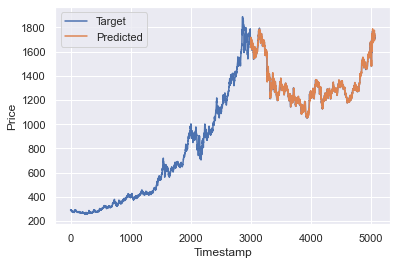

In [21]:
prices_pred = np.empty_like(X)
prices_pred[:] = np.nan
prices_pred[train_len + future_len:, 0] = y_test_pred[train_len:]

plt.figure()
plt.plot(scaler.inverse_transform(y_test), label='Target')
plt.plot(scaler.inverse_transform(prices_pred), label='Predicted')
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()

Disclaimer: We are signal processing experts, not financial advisors. Do not use any of the models presented herein to steer your investments.